### 🛠️ Step 0: 初期設定と環境セットアップ

このステップでは、ノートブックの冒頭に書く **ハイパーパラメータやデバイス設定などの共通設定ブロック** を構築します。

#### 💡 含まれる要素：

- 予測するカラム（`TARGET_COLS`）の指定
- バッチサイズや画像サイズなどのハイパーパラメータ
- ファイルパスの一元管理
- デバイス（CUDA / MPS / CPU）の自動判定（Mac対応）
- tqdm / torchinfo の導入（今後の学習・表示改善のため）

#### 🔥 利点：

- 「設定を一箇所に集約」しておくことで、ノートブック全体が見通しやすくなります
- 他のパラメータに拡張・変更するときにも柔軟に対応できます

In [28]:
# === ライブラリの読み込み ===
import torch
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torchinfo import summary  # pip install torchinfo

# === パラメータ設定 ===
TARGET_COLS = ["dipCount", "hue", "circleCount"]  # 予測対象のパラメータ名を指定
IMAGE_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
PREFIX = "image_"

# === ディレクトリ設定 ===
DATA_DIR = Path("../../data/circle-stroke")
CSV_PATH = DATA_DIR / "metadata.csv"
IMG_DIR = DATA_DIR / "images"

# === デバイス自動判定（MacのMPS含む）===
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

✅ Using device: mps


### 📘 Step 1: メタデータの読み込みと複数ターゲット列の抽出

このステップでは、`metadata.csv` を読み込み、  
学習の **入力（画像）と出力（複数のパラメータ）** を構成するために必要な情報を準備します。

#### 🔍 目的：
- 必要なターゲット列（`dipCount`, `hue`, `circleCount`, ...）を一括で抽出
- `id` から画像ファイル名を組み立てる
- 実在する画像ファイルのみを対象にフィルタリング

#### 🧠 構造上のポイント：
- ターゲット列は `TARGET_COLS` に事前定義（Step 0で）
- `"image_" + id + ".png"` 形式でファイル名を生成
- `.exists()` を使って実在チェック

In [29]:
import pandas as pd

# CSV読み込み
df = pd.read_csv(CSV_PATH)

# id と、複数のターゲット列だけを抜き出す
df_targets = df[["id"] + TARGET_COLS].copy()

# ファイル名とフルパスを作成
df_targets["filename"] = df_targets["id"].apply(lambda x: f"{PREFIX}{x}.png")
df_targets["filepath"] = df_targets["filename"].apply(lambda x: IMG_DIR / x)

# 実在する画像ファイルだけにフィルタリング
df_targets = df_targets[df_targets["filepath"].apply(lambda x: x.exists())].reset_index(drop=True)

# チェック
print(f"✅ 使用可能なデータ数: {len(df_targets)}")
print(f"🎯 ターゲット列: {TARGET_COLS}")

✅ 使用可能なデータ数: 999
🎯 ターゲット列: ['dipCount', 'hue', 'circleCount']


### 📘 Step 2: マルチラベル対応の Dataset クラス定義（hueベクトル変換つき）

このステップでは、複数の出力ラベル（`dipCount`, `hue_cos`, `hue_sin`）に対応できるように  
PyTorchの `Dataset` クラスを拡張します。

#### ✅ 主なポイント：
- `hue` を角度 → `(cos, sin)` に変換して2次元ベクトルとして扱う
- 出力ラベルを `[dipCount, hue_cos, hue_sin]` の **3次元ベクトル**として返す
- `image` と `label` をセットで返す構成はそのまま

#### 📌 入力・出力形式：
- 入力：画像（RGB）
- 出力：torch.Tensor([dipCount, hue_cos, hue_sin])

In [30]:
import numpy as np

class MultiParamDataset(Dataset):
    def __init__(self, df, img_dir, image_size=128, prefix="image_"):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.prefix = prefix
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ファイルパス構築
        img_filename = f"{self.prefix}{row['id']}.png"
        img_path = self.img_dir / img_filename
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ラベル構築（dipCount + hueをcos/sinに変換）
        dip = row["dipCount"]
        hue_deg = row["hue"]
        hue_rad = np.deg2rad(hue_deg)
        hue_cos, hue_sin = np.cos(hue_rad), np.sin(hue_rad)

        label = torch.tensor([dip, hue_cos, hue_sin], dtype=torch.float32)

        return image, label

画像サイズ: torch.Size([3, 128, 128])
ラベル（[dipCount, hue_cos, hue_sin]）: tensor([ 3.0000,  0.8290, -0.5592])


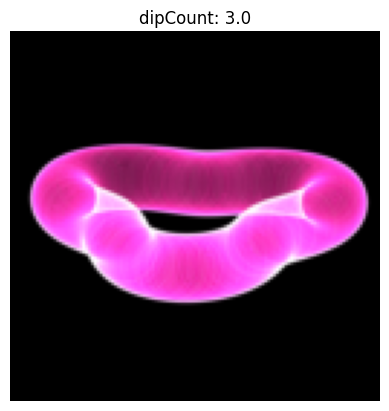

In [31]:
# 動作確認：最初の1件を取り出して、ラベルの中身を確認
sample_dataset = MultiParamDataset(df_targets, IMG_DIR)
sample_img, sample_label = sample_dataset[0]

print("画像サイズ:", sample_img.shape)
print("ラベル（[dipCount, hue_cos, hue_sin]）:", sample_label)

# 簡単な画像表示
import matplotlib.pyplot as plt

plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"dipCount: {sample_label[0]:.1f}")
plt.axis("off")
plt.show()

### 📘 Step 3: データの訓練・検証分割と DataLoader の作成

このステップでは、前のステップで作成した `MultiParamDataset` を使って、
訓練用・検証用のデータを分割し、それぞれに対して PyTorch の `DataLoader` を用意します。

#### ✅ 主な目的：
- `train_test_split` を使って 80:20 の比率で訓練/検証データを分ける
- PyTorch の `DataLoader` を使って、データをミニバッチ化して供給できるようにする
- 検証データはシャッフルせず、順番を保ったままにする

#### 📌 結果：
- `train_loader` / `val_loader` ができると、`for images, labels in loader:` の形でミニバッチを簡単に扱えるようになります

In [32]:
from sklearn.model_selection import train_test_split

# 訓練/検証分割（20%を検証に）
df_train, df_val = train_test_split(df_targets, test_size=0.2, random_state=42)

# Dataset のインスタンスを作成
train_dataset = MultiParamDataset(df_train, IMG_DIR, image_size=IMAGE_SIZE, prefix=PREFIX)
val_dataset = MultiParamDataset(df_val, IMG_DIR, image_size=IMAGE_SIZE, prefix=PREFIX)

# DataLoader の作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ train: {len(train_dataset)} samples | val: {len(val_dataset)} samples")

✅ train: 799 samples | val: 200 samples


In [33]:
# 1バッチ取り出して内容を確認
images, labels = next(iter(train_loader))

print("🔍 バッチ画像 shape:", images.shape)   # (B, 3, H, W)
print("🔍 バッチラベル shape:", labels.shape) # (B, 3) → [dipCount, hue_cos, hue_sin]
print("🎯 ラベルの一部:", labels[:4])         # 最初の4件のラベルを確認

🔍 バッチ画像 shape: torch.Size([32, 3, 128, 128])
🔍 バッチラベル shape: torch.Size([32, 3])
🎯 ラベルの一部: tensor([[ 4.0000, -0.8339,  0.5519],
        [ 4.0000, -0.9942, -0.1080],
        [12.0000, -0.6833, -0.7302],
        [11.0000,  0.9966,  0.0819]])


### 📘 Step 4: 複数パラメータ出力に対応した CNN モデルの定義

このステップでは、画像を入力として `dipCount`, `hue_cos`, `hue_sin` の3つの値を同時に出力できる  
**多出力（multi-output）CNNモデル**を定義します。

#### ✅ 主な変更点：
- 出力層（`fc2`）のユニット数を **1 → 3** に変更
- 出力は `[batch_size, 3]` のテンソルで返されます

#### 🔧 注意点：
- hue は `cos`, `sin` に変換済みなので、出力には活性化関数は不要（float値で回帰）

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class MultiParamCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), 64)
        self.fc2 = nn.Linear(64, 3)  # dipCount, hue_cos, hue_sin

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
# モデルインスタンス化 & デバイスに送る
model = MultiParamCNN().to(device)

# 構造とパラメータ数を表示
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
MultiParamCNN                            [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 128, 128]        448
├─MaxPool2d: 1-2                         [32, 16, 64, 64]          --
├─Conv2d: 1-3                            [32, 32, 64, 64]          4,640
├─MaxPool2d: 1-4                         [32, 32, 32, 32]          --
├─Linear: 1-5                            [32, 64]                  2,097,216
├─Linear: 1-6                            [32, 3]                   195
Total params: 2,102,499
Trainable params: 2,102,499
Non-trainable params: 0
Total mult-adds (M): 910.17
Input size (MB): 6.29
Forward/backward pass size (MB): 100.68
Params size (MB): 8.41
Estimated Total Size (MB): 115.38

### 📘 Step 5: マルチ出力モデルの学習ループ（dipCount + hue_cos/sin）

このステップでは、Step 4で定義したマルチ出力CNNモデルに対して、  
複数パラメータを同時に学習できるようにした学習ループを構築します。

#### ✅ 主な変更点：
- 出力は `[dipCount, hue_cos, hue_sin]` の3次元ベクトル
- ラベルもそれに合わせて `[B, 3]` になる
- そのまま `MSELoss()` を使えばOK（各要素ごとの誤差を平均してくれる）

#### ✅ 新たに導入する要素：
- `tqdm` による進捗バー表示（バッチ単位）
- epochごとの損失表示に加え、3つの出力それぞれの誤差もチェックしやすくなる

In [36]:
import wandb

# --- wandb 初期化 ---
wandb.init(
    project="parametric-visual-learning",
    name="image2params_multi",
    config={
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "target_cols": TARGET_COLS,
        "image_size": IMAGE_SIZE,
    }
)

# --- モデル・損失・最適化設定 ---
model = MultiParamCNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

# --- 学習ループ ---
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- 検証ループ ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # --- wandbログ記録 ---
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"[{epoch+1}] 🟢 Train Loss: {avg_train_loss:.4f} | 🔵 Val Loss: {avg_val_loss:.4f}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kimurakoya (ritsumeikan-math). Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s, loss=1.99]


[1] 🟢 Train Loss: 2.9344 | 🔵 Val Loss: 2.1832


Epoch 2/10: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s, loss=1.3] 


[2] 🟢 Train Loss: 1.5883 | 🔵 Val Loss: 1.7396


Epoch 3/10: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s, loss=0.656]


[3] 🟢 Train Loss: 1.2694 | 🔵 Val Loss: 1.2670


Epoch 4/10: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s, loss=0.357]


[4] 🟢 Train Loss: 0.6873 | 🔵 Val Loss: 0.5770


Epoch 5/10: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s, loss=0.223] 


[5] 🟢 Train Loss: 0.2217 | 🔵 Val Loss: 0.1961


Epoch 6/10: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s, loss=0.113] 


[6] 🟢 Train Loss: 0.1149 | 🔵 Val Loss: 0.1699


Epoch 7/10: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s, loss=0.0983]


[7] 🟢 Train Loss: 0.1054 | 🔵 Val Loss: 0.2504


Epoch 8/10: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s, loss=0.0982]


[8] 🟢 Train Loss: 0.0813 | 🔵 Val Loss: 0.1040


Epoch 9/10: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, loss=0.0262]


[9] 🟢 Train Loss: 0.0625 | 🔵 Val Loss: 0.1152


Epoch 10/10: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s, loss=0.0593]


[10] 🟢 Train Loss: 0.0442 | 🔵 Val Loss: 0.0818


In [37]:
# モデルを推論モードにして1バッチ予測
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    preds = model(images)

print("🎯 正解ラベル（前4件）:")
print(labels[:4])

print("🤖 モデル予測（前4件）:")
print(preds[:4])

🎯 正解ラベル（前4件）:
tensor([[10.0000, -0.9593, -0.2823],
        [ 3.0000,  0.9792, -0.2028],
        [ 5.0000,  0.0628, -0.9980],
        [ 5.0000,  0.8746,  0.4848]], device='mps:0')
🤖 モデル予測（前4件）:
tensor([[10.5420, -1.0125, -0.1537],
        [ 3.0499,  1.0188, -0.1758],
        [ 4.9837,  0.0940, -0.9524],
        [ 5.0013,  0.7776,  0.6191]], device='mps:0')


### 📘 Step 6: モデル予測の可視化とパラメータ別評価

このステップでは、検証データを使って以下を行います：

- `dipCount` の予測値と真値を数値として比較
- `hue_cos`, `hue_sin` の予測を角度に戻して、hue の予測角度と真値を比較
- 画像を表示し、モデルの予測と真値を画像上に描画

#### ✅ hue角度の逆変換：
```python
theta_deg = np.rad2deg(np.arctan2(sin, cos)) % 360
```
- `arctan2` は `(sin, cos)` をラジアンの角度に戻す関数
- `% 360` で [0, 360) の範囲に補正

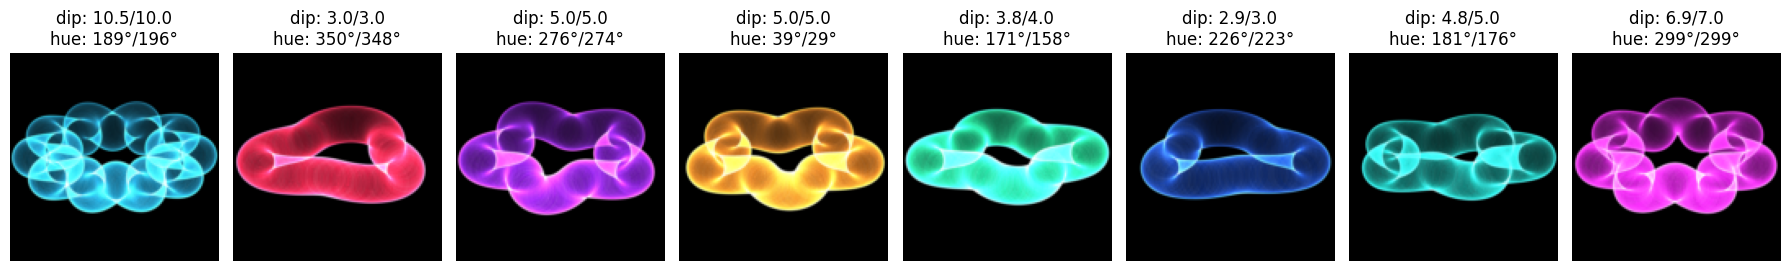

In [38]:
model.eval()

num_samples = 8
plt.figure(figsize=(18, 4))

for i in range(num_samples):
    image, label = val_dataset[i]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu()

    # ラベル値の分解
    dip_gt, hue_cos_gt, hue_sin_gt = label.tolist()
    dip_pred, hue_cos_pred, hue_sin_pred = pred.tolist()

    # hueを角度に逆変換
    hue_gt = np.rad2deg(np.arctan2(hue_sin_gt, hue_cos_gt)) % 360
    hue_pred = np.rad2deg(np.arctan2(hue_sin_pred, hue_cos_pred)) % 360

    # 可視化
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"dip: {dip_pred:.1f}/{dip_gt:.1f}\nhue: {hue_pred:.0f}°/{hue_gt:.0f}°")
    plt.axis("off")

plt.tight_layout()
plt.show()

### 📘 Step 7: ロスカーブ（損失推移）の可視化

このステップでは、Step 5で記録しておいた `train_losses` と `val_losses` の推移を折れ線グラフとして表示し、  
**学習が適切に進んでいたかどうかを視覚的に確認**します。

#### ✅ チェックポイント：
- Train/Val 両方のロスが **滑らかに減少している** → ◎
- Valロスが増え出す場合 → 過学習の兆候
- ほぼ変化しない場合 → 学習できていない可能性あり

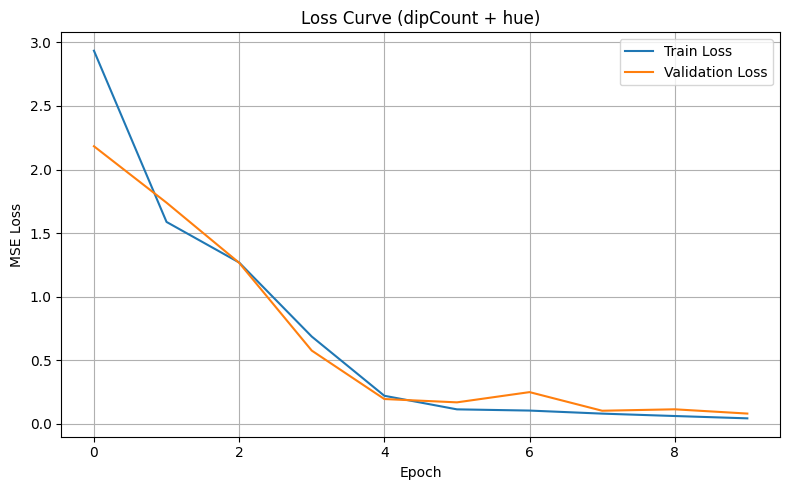

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (dipCount + hue)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()